# Analyzing Our Trained Embeddings
---

### Import Dependencies

In [1]:
# First - need to import sys and os and nav to our project_root
import sys
import os

project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Now import our dependencies
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tokenizer.tokenizer import MyTokenizer
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import tokenizer
tokenizer = MyTokenizer()
tk_vocab_size = tokenizer.get_vocab_size()

Using device: cuda


### Import our Model

In [3]:
# Continuous Bag of Words model for training embeddings as specified in Word2Vec (https://arxiv.org/pdf/1301.3781.pdf)
class CBOW_NegativeSampling(nn.Module):
    def __init__(self, embed_dim, tokenizer, effic_strat=None, vocab_size=tk_vocab_size, device=device):
        """
        Inputs:
            embed_dim:   (int) number of dimensions for our embeddings
            effic_strat: (str) either 'neg-sample' or 'hier-softmax' - used to define which strategy for efficient computation to use
            vocab_size:  (int) the size of the vocabulary
            device:      Pytorch device (cuda / cpu)
        """
        super().__init__()
        self.device = device
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.token_frequencies = tokenizer.get_frequency_tensor().to(device)
        self.embeddings = nn.Embedding(vocab_size, embed_dim).to(device)
        
        self.initialize_embeddings()

    def initialize_embeddings(self):
        """ Initializes the embedding weights to a normal distribution with mean 0 and a specified variance """
        nn.init.normal_(self.embeddings.weight, mean=0.0, std=1)

    def forward(self, context_indices, positive_indices, num_negative_samples=5):
        """
            Performs a forward pass with negative sampling.
            
            Parameters:
            - context_indices: Indices of the context words [B, Context_size].
            - positive_indices: Indices of the target (positive) words [B, 1].
            - num_negative_samples: Number of negative samples per positive sample.
        """
        # Get the embeddings for our context vectors and average -- will use this to estimate for our positive and negative samples
        batch_size = context_indices.size(0)
        context_embeds = self.embeddings(context_indices).mean(dim=1, keepdims=True)         # [B, context_size, embed_dim] --> [B x 1 x embed_dim]
    
        # Compute loss on positive samples (what we're looking for)
        positive_embeds = self.embeddings(positive_indices).unsqueeze(-1)                    # [B, embed_dim, 1]
        positive_logits = torch.bmm(context_embeds, positive_embeds).squeeze()               # [B x 1 x embed_dim] @ [B, embed_dim, 1] -> [B, 1, 1] -> [B]
        positive_labels = torch.ones_like(positive_logits)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, positive_labels) # [B]
    
        # Compute loss on negative samples (teach model to move negative samples away from each other
        negative_indices = torch.multinomial(self.token_frequencies, num_samples=batch_size*num_negative_samples, replacement=True).reshape(batch_size, num_negative_samples)
        negative_embeds = self.embeddings(negative_indices).transpose(1,2)                   # [B, embed_dim, num_negative_samples]
        negative_logits = torch.bmm(context_embeds, negative_embeds).squeeze()               # [B, num_negative_samples]
        negative_labels = torch.zeros_like(negative_logits)
        negative_loss = F.binary_cross_entropy_with_logits(negative_logits, negative_labels) # [B, num_negative_samples]

        return positive_loss + negative_loss.mean()   # [B]

    def find_closest_embeddings(self, input_embedding, n=5):
        """
            Find the n embeddings in the model that have the largest cosine similarity
            to the given input_embedding.
    
            Inputs:
                input_embedding (Tensor): The input embedding vector.
                n (int): The number of closest embeddings to return.
    
            Returns a tensor of indices of the n closest embeddings.
        """
        input_embedding_norm = input_embedding / input_embedding.norm()                    # [1 x emb_dim]
        all_embeddings = self.embeddings.weight
        all_embeddings_norm = all_embeddings / all_embeddings.norm(dim=1, keepdim=True)    # [vocab_size x emb_dim]
        similarities = F.cosine_similarity(input_embedding_norm, all_embeddings_norm, dim=1)
        values, indices = torch.topk(similarities, n)
        return indices

    def get_embedding(self, index):
        """ Retrieve the vector embedding corresponding to a given index Returns a tensor of the embedding vector """
        return self.embeddings.weight[index]

    def save_weights(self, filename):
        """ Save the model weights to a file """
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        """ Load the model weights from a file. Ex. 'trained_models/mymodel.pth' """
        self.load_state_dict(torch.load(filename, map_location=self.device))
        print(f"Model weights loaded from {filename}")

In [4]:
# Import and load our model weights
model_fn = "CBOW-5-NS-16k-2024-04-20_23-29"
mymodel = CBOW_NegativeSampling(embed_dim=512, tokenizer=tokenizer)
mymodel.load_weights(os.path.join("trained_models", model_fn+".pth"))
embeds = mymodel.embeddings.weight.detach()

Model weights loaded from trained_models\CBOW-5-NS-16k-2024-04-20_23-29.pth


### Cosine Similarity to Understand Semantic Meaning
---
**1)** See what words are the most similar to our target word   
**2)** Word vector algebra (similar to the Word2Vec paper)

In [32]:
def print_closest_ids(string):
    tok = tokenizer.encode_as_ids(string)
    tok_text = tokenizer.encode_as_pieces(string)
    if len(tok)>1:
        print("Try new token - token length > 1")
        return

    token_embedding = mymodel.get_embedding(tok)
    closest_ids = mymodel.find_closest_embeddings(token_embedding, n=11)
    closest_ids = (closest_ids.to('cpu')).flatten().tolist()
    print(f"Closest tokens for: {string}\nToken: {tok} - {tok_text}\n{'-'*60}")
    for i, id in enumerate(closest_ids):
        if i == 0:
            continue
        print(f"Id: {i} - {tokenizer.decode(id)}")

# Testing
test_word = "England"
print_closest_ids(test_word)

Closest tokens for: England
Token: [2676] - ['▁England']
------------------------------------------------------------
Id: 1 - France
Id: 2 - Ireland
Id: 3 - Scotland
Id: 4 - New
Id: 5 - Spain
Id: 6 - Church
Id: 7 - Rome
Id: 8 - Italy
Id: 9 - London
Id: 10 - Mexico


In [36]:
# Defining a - b + c = ?
def closest_arith(a, b, c, n=10):
    
    tok_a = tokenizer.encode_as_ids(a)
    tok_b = tokenizer.encode_as_ids(b)
    tok_c = tokenizer.encode_as_ids(c)
    
    if (len(tok_a) + len(tok_b) + len(tok_c)) > 3:
        print("Words not single tokens")
        return
    
    emb_a = mymodel.get_embedding(tok_a)
    emb_b = mymodel.get_embedding(tok_b)
    emb_c = mymodel.get_embedding(tok_c)

    new_emb = (emb_a - emb_b + emb_c)
    new_emb = new_emb / new_emb.norm()
    closest_ids = mymodel.find_closest_embeddings(new_emb, n)
    closest_ids = (closest_ids.to('cpu')).flatten().tolist()
    print(f"Closest tokens for: '{a}' - '{b}' + '{c}'\n{'-'*60}")
    for i, id in enumerate(closest_ids):
        print(f"Id: {i+1} - {tokenizer.decode(id)}")

a = "London"
b = "England"
c = "France"
closest_arith(a, b, c)

Closest tokens for: 'London' - 'England' + 'France'
------------------------------------------------------------
Id: 1 - London
Id: 2 - France
Id: 3 - Paris
Id: 4 - March
Id: 5 - Italy
Id: 6 - namely
Id: 7 - ,
Id: 8 - May
Id: 9 - Germany
Id: 10 - ville


### Conduct PCA
---
**1)** We see that the singular values are all important. This is good! This shows that our word embeddings took advantage of all the dimensions available during training.   
**2)** In order to visualize our data, let's pull a subset of words that are similar to each other to see how the data differs.

In [5]:
# Compute SVD
U, S, Vt = torch.svd(F.normalize(embeds.T, dim=0))
print(f"U: {U.shape}\nS: {S.shape}\nVt: {Vt.shape}")
print(f"{'-'*50}\nMax SV: {S.max():.3f}\nMin SV: {S.min():.3f}")

U: torch.Size([512, 512])
S: torch.Size([512])
Vt: torch.Size([16384, 512])
--------------------------------------------------
Max SV: 29.435
Min SV: 4.320


In [22]:
# words = ["large", "small", "number", "considerable", "very", "larger", "big"]
# words = ["red", "blue", "yellow", "brown", "black", "green", "purple", "white"]
# words = ["large", "small", "number", "very", "big", "green", "yellow", "blue", "white", "black"]
# words = ["tear", "cry", "cried", "separate", "divided", "separated"]
words = ["boy", "girl", "child", "lady", "woman", "mother", "green", "yellow", "blue", "white", "black"]
# words = ["Japan", "England", "France", "Germany", "Tokyo", "London", "Paris", "Berlin"]

# Confirm words are all a single token
all_singles = True
for word in words:
    if len(tokenizer.encode_as_pieces(word)) > 1:
        print(f"\"{word}\" is multiple tokens")
        all_singles = False
if all_singles:
    print("All words are one token!")

All words are one token!


In [23]:
# Conducting PCA - given the high-dimensionality, even words that are 'close' to each other (cos. sim.) have different dimensionality associated with each other
word_embs = mymodel.embeddings(torch.tensor(tokenizer.encode_as_ids(words), device=device)).squeeze(1)     # [words x emb_dims]
word_embs = word_embs - word_embs.mean(dim=0)         # Subtract the mean
U, S, Vt = torch.linalg.svd(word_embs.T)                     # Compute SVD w.r.t. transpose ([emb_dims x words])

# We want to plot the first 3 rows of Vt (gives us shape [3 x words]) as these are the principle components
prin_comp = Vt[:3, :].detach().cpu().numpy()

# Casting to 2-d
twod_adj = np.eye(3)
twod_adj[2,2] = 0
twod_adj[1,1] = 0

prin_comp = S[:3].detach().cpu().numpy()*np.eye(3) @ prin_comp

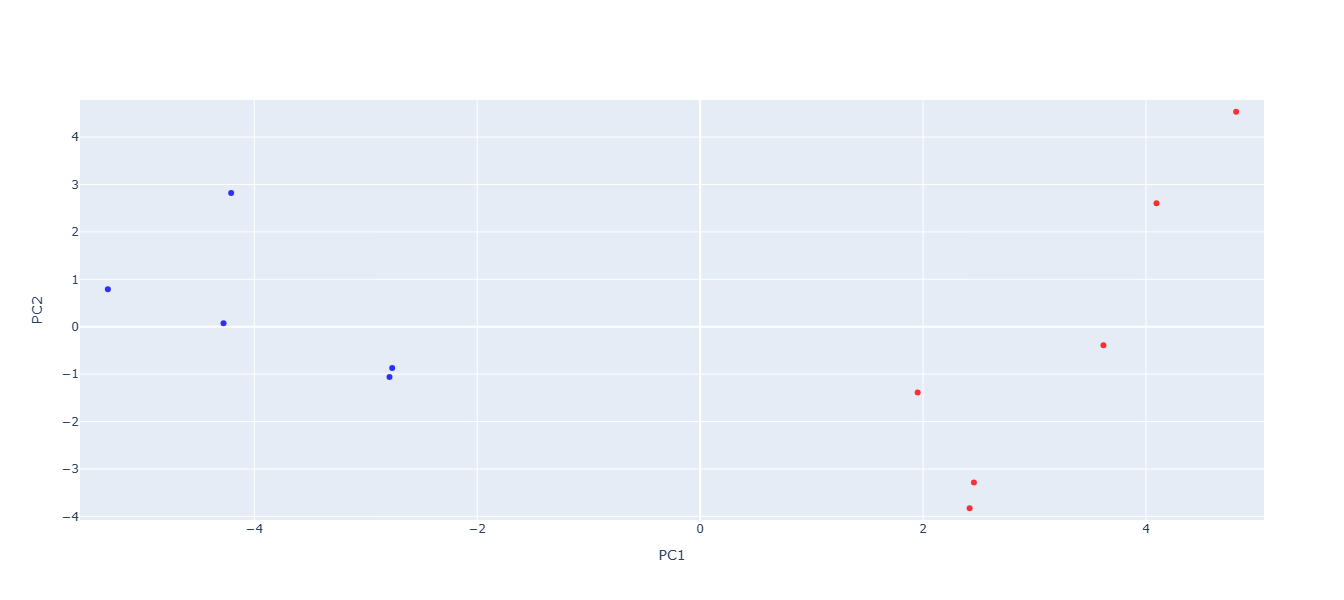

In [27]:
# Create a scatter plot for the first two or three principal components
x_split = 6  # Number of points to color differently
colors = ['red' if i < x_split else 'blue' for i in range(len(prin_comp[0]))]

# Add a small border to avoid dots on the edge
border = 0.25

# Uncomment the following lines to enable 3D plotting
# scatter = go.Scatter3d(
#     x=prin_comp[0],
#     y=prin_comp[1],
#     z=prin_comp[2],
#     mode='markers',
#     marker=dict(
#         size=6,
#         color=colors,  # Dynamic coloring based on the index
#         opacity=0.8
#     )
# )
# fig = go.Figure(data=[scatter], layout=go.Layout(
#     scene=dict(
#         xaxis=dict(title='PC1', range=[np.min(prin_comp[0]) - border, np.max(prin_comp[0]) + border]),
#         yaxis=dict(title='PC2', range=[np.min(prin_comp[1]) - border, np.max(prin_comp[1]) + border]),
#         zaxis=dict(title='PC3', range=[np.min(prin_comp[2]) - border, np.max(prin_comp[2]) + border])
#     ),
#     width=800,
#     height=600
# ))

# By default, create a 2D scatter plot
scatter = go.Scatter(
    x=prin_comp[0],
    y=prin_comp[1],
    mode='markers',
    marker=dict(
        size=6,
        color=colors,  # Dynamic coloring based on the index
        opacity=0.8
    )
)

fig = go.Figure(data=[scatter], layout=go.Layout(
    xaxis=dict(title='PC1', range=[np.min(prin_comp[0]) - border, np.max(prin_comp[0]) + border]),
    yaxis=dict(title='PC2', range=[np.min(prin_comp[1]) - border, np.max(prin_comp[1]) + border]),
    width=800,
    height=600
))

# Show plot
fig.show()
